# Data Download

In [9]:
import pandas as pd
import numpy as np
# use NVIDIA RAPIDS
import cudf
import cuml
import cupy as cp
!nvidia-smi

Mon Oct  6 04:58:20 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   75C    P0             33W /   70W |     114MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Download the processed data (taken from jupyter notebook).

In [2]:
import gdown
import pickle

gdown.download('https://drive.google.com/file/d/1gOjaG-u6Dou1OK6rUkdcE2hwtWjKWc8k/view?usp=drive_link', 'windowed_data_dict.pkl', fuzzy=True)

with open('windowed_data_dict.pkl', 'rb') as f:
    data = pickle.load(f)

print('\n')
for key in data:
    print(f'{key}: {len(data[key])}')

Downloading...
From: https://drive.google.com/uc?id=1gOjaG-u6Dou1OK6rUkdcE2hwtWjKWc8k
To: /content/windowed_data_dict.pkl
100%|██████████| 22.6M/22.6M [00:00<00:00, 75.8MB/s]




x: 3091
y: 3091
z: 3091


# Select Features

**Features:** Extract 7 features per channel (xyz) so we have a feature vector of shape (1,21) though do note that it could be better to reshape it as a (3,7) feature matrix. However I don't believe that simpler unsupervised methods account for spatial relationships this way so I will leave it as (1,7). We have one of these feature vectors per window, accounting for signal properties relating to tremors:

| Signal Property of Interest | Feature Representation |
|:----------------------------|:-----------------------|
| Basic Shape of Signal | Mean, Standard Deviation (std) |
| Average Energy | Root Mean Square (rms) |
| Oscillatory Behaviour | Zero Crossings |

Mean, std, and rms will be computed for the current value as well as the derivative at that point by approximating it using a first difference. Together that should give properties that define the shape of the signal as well as its average "energy".
Zero crossings is an important addition since tremors are rapid acceleration in opposing/different directions, so seeing when the raw accelerometer data goes back and forth over 0 represents its oscilatory behaviour. Note: Crossing zero only works here since we are observing resting tremor when the accelerometer's drift is removed. This feature is misleading when voluntary movement is added since an acceleration offset would be introduced.

In [17]:
gdf = cudf.DataFrame()

for key in data:
    mean = []
    std = []
    rms = []
    diff_mean = []
    diff_std = []
    diff_rms = []
    zero_crossings = []

    for window in data[key]:
        mean.append(np.mean(window))
        std.append(np.std(window))
        diff_mean.append(np.mean(np.diff(window)))
        diff_std.append(np.std(np.diff(window)))
        diff_rms.append(np.sqrt(np.mean(window**2)))
        rms.append(np.sqrt(np.mean(window**2)))
        sign_mask = np.diff(np.sign(window)) != 0
        zero_crossings.append(np.sum(sign_mask))

    gdf[f'{key}_mean'] = mean
    gdf[f'{key}_std'] = std
    gdf[f'{key}_rms'] = rms
    gdf[f'{key}_diff_mean'] = diff_mean
    gdf[f'{key}_diff_std'] = diff_std
    gdf[f'{key}_diff_rms'] = diff_rms
    gdf[f'{key}_zero_crossings'] = zero_crossings

gdf.head()

,x_mean,x_std,x_rms,x_diff_mean,x_diff_std,x_diff_rms,x_zero_crossings,y_mean,y_std,y_rms,...,y_diff_std,y_diff_rms,y_zero_crossings,z_mean,z_std,z_rms,z_diff_mean,z_diff_std,z_diff_rms,z_zero_crossings
0,1515.011202,23552.991682,23601.666808,-0.220061,9337.481227,23601.666808,30,-1708.054460,26647.824254,26702.509011,...,10243.486490,26702.509011,26,1865.900669,19450.545772,19539.839204,11.560370,7525.332442,19539.839204,29
1,1152.140395,22430.473270,22460.043602,8.967072,8966.870476,22460.043602,28,-2209.195321,25475.655363,25571.264344,...,9801.379428,25571.264344,22,2476.855967,18734.684156,18897.703721,4.865720,7025.541044,18897.703721,28
2,526.255387,18905.766001,18913.088928,-11.979169,7376.227118,18913.088928,26,-2251.342164,24564.149685,24667.103423,...,8582.724825,24667.103423,23,2792.564801,18660.264974,18868.065801,-14.741092,5842.720542,18868.065801,25
3,-453.747071,15560.702385,15567.316568,3.811679,5377.901643,15567.316568,23,-1965.353968,27182.512645,27253.469686,...,7355.561089,27253.469686,21,2675.909788,21537.708362,21703.303313,-1.340546,4767.143302,21703.303313,24
4,-1042.499489,15320.614117,15356.041877,-5.654660,4181.936805,15356.041877,21,-1581.295955,32176.223300,32215.056150,...,6818.885136,32215.056150,23,1967.972331,25732.504439,25807.648088,2.699582,4446.140622,25807.648088,23


# Clustering (unsupervised): KMeans

**Clustering:** Now we employ unsupervised methods to cluster the feature representations to observe if there are distinct groups. Of course we are hoping to see some divide between tremor and non-tremor window samples. For this we can try KMeans which allows us to specify the number of clusters which is helpful for our use case since ideally, we will find 2 distinct groups (tremor, non-tremor). Though we will also try 3 clusters if there is some difference between non-tremor, pre-tremor, and tremor phases.

In [4]:
from cuml.cluster import KMeans

kmeans_2 = KMeans(n_clusters=2, max_iter=300, random_state=20)
kmeans_2.fit(gdf)

# use the same random state for consistency
kmeans_3 = KMeans(n_clusters=3, max_iter=300, random_state=20)
kmeans_3.fit(gdf)

KMeans()

Store the cluster label results in k_meansdf. Notice that window 0 is labeled as class 1 by KMeans with n_clusters=2 and class 0 for KMeans with n_clusters=3. Note that this does not inherently say anything about whether they have been labeled as separate classes, it is simply a product of the arbitriray labeling convention used by each.

Also consider that n_cluster could be greater than those assummed classes if there are some significant differences between signals of different tremor itensities. This will not be a factor within the scope of this notebook because all samples derive from a single patient with data being recorded in one sitting as well, so intensity should be relatively consistent. **BUT** this is important to note when trying to generalize the model to work for different patients which may have tremors of various intensities.

In [10]:
kmeans_2_labels = kmeans_2.labels_
kmeans_3_labels = kmeans_3.labels_

k_meansdf = cudf.DataFrame()
k_meansdf['kmeans_2_labels'] = kmeans_2_labels
k_meansdf['kmeans_3_labels'] = kmeans_3_labels

k_meansdf.head()

,kmeans_2_labels,kmeans_3_labels
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0


We can mathematically observe the clusters using their independent cluster variances (how tight each cluster is) as well as the total variance (how well the overall grouping is).

In [32]:
lbl_2 = kmeans_2.labels_
centroid_2 = kmeans_2.cluster_centers_
lbl_3 = kmeans_3.labels_
centroid_3 = kmeans_3.cluster_centers_

# add KMeans labels to gdf
# gdf_lbl = gdf.merge(k_meansdf, left_index=True, right_index=True)

variance_2 = cp.zeros((2,))
variance_3 = cp.zeros((3,))

# independent variance for n_clusters = 2
for i in range(kmeans_2.n_clusters):
    vectors_in_cluster = gdf[lbl_2 == i].to_cupy()
    variance_2[i] = cp.mean(cp.sum((vectors_in_cluster - centroid_2.iloc[i].to_cupy()) ** 2, axis=1))

# independent variance for n_clusters = 3
for i in range(kmeans_3.n_clusters):
    vectors_in_cluster = gdf[lbl_3 == i].to_cupy()
    variance_3[i] = cp.mean(cp.sum((vectors_in_cluster - centroid_3.iloc[i].to_cupy()) ** 2, axis=1))

counts_2 = cp.bincount(lbl_2.to_cupy())
counts_3 = cp.bincount(lbl_3.to_cupy())

# weighted sum of independent cluster variances / total samples = total variance
kmeans_2_var = (cp.sum(variance_2 * counts_2)/len(gdf)).get()
kmeans_3_var = (cp.sum(variance_3 * counts_3)/len(gdf)).get()


print(f'Counts for KMeans with n_clusters=2: {counts_2}')

print(f'Counts for KMeans with n_clusters=3: {counts_3}')

print(f'Total variance per sample KMeans with n_clusters=2: {kmeans_2_var}')
print(f'Total variance per sample for KMeans with n_clusters=3: {kmeans_3_var}')

Counts for KMeans with n_clusters=2: [2890  201]
Counts for KMeans with n_clusters=3: [ 212 2864   15]
Total variance for KMeans with n_clusters=2: 336024686.8950472
Total variance for KMeans with n_clusters=3: 213317003.0448627


Now, let's try with other values for n_clusters to see if 2 or 3 is optimal or if the relationships (found by KMeans) are more nuanced than our initial assumption. To gauge this, we plot variance over values for n_clusters and apply "Elbow Rule" to determine optimal K (n_clusters).

In [40]:
# variance per sample for different value of Ks (i.e. n_clusters)
K = 10
variance_K =  []
for k in range(1,K+1):
    kmeans = KMeans(n_clusters=k, max_iter=300, random_state=20)
    kmeans.fit(gdf)
    variance_K.append(kmeans.inertia_/len(gdf))

k = np.arange(1,K+1)
variance_K = np.array(variance_K)
var_reduction = 1 - variance_K/variance_K[0]

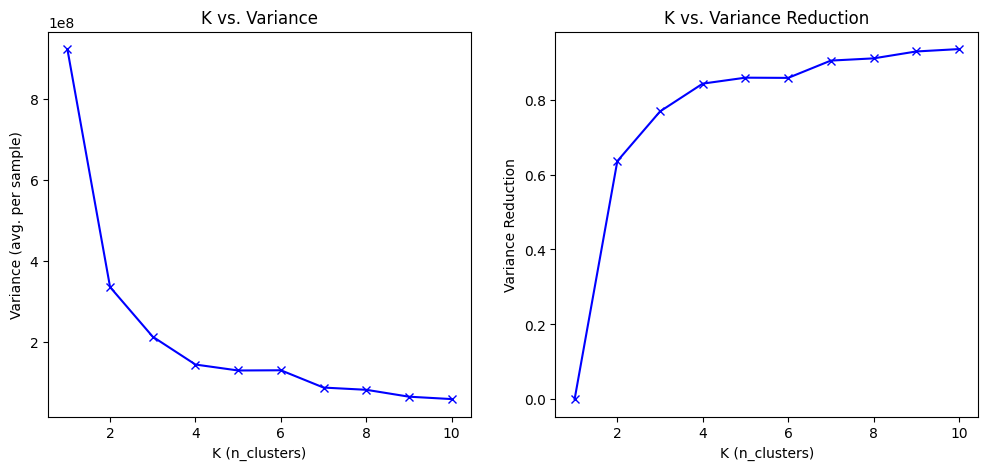

In [41]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].plot(k, variance_K, 'bx-')
ax[0].set_xlabel('K (n_clusters)')
ax[0].set_ylabel('Variance (avg. per sample)')
ax[0].set_title('K vs. Variance')

ax[1].plot(k, var_reduction, 'bx-')
ax[1].set_xlabel('K (n_clusters)')
ax[1].set_ylabel('Variance Reduction')
ax[1].set_title('Elbow Plot')

plt.show()

# Conclusion and Final Remarks

**Results:** Notice the second plot (right), there is a big variance reduction from K=1 to K=2 and by K=4 there are no more noticeable gains. The thing with KMeans is that variance will naturally go to 0 as K approaches the number of samples since if you assign a cluster center to each sample you get 0 variance. So the "Eblow Rule" essentially says, instead look at the values K where the variance reduction step is the largest and where it begins to flat line, those are the most likely viable K values. Side-note: It is called the elbow rule since that's where the noticeable bend is, like an elbow.

**Conclusion:** We can conclude that there is in fact a "learnable" diffrentiation between different classes in this tremor dataset. From the Elbow Plot, we have that K=2, K=3, and even perhaps K=4 are the most representative number of clusters in our data which alligns with our assumption and intention or predicting tremor vs. non-tremor classes (with another candidate class of pre-tremor). If unsupervised methods can differentiate these groups, our modern deep learning methods should be able to do a better job. This notebook proves that the our data is not simply noise and is potentially viable for training.